Processing files across 5 seed directories...
Visualization saved to race_prediction_accuracy.png


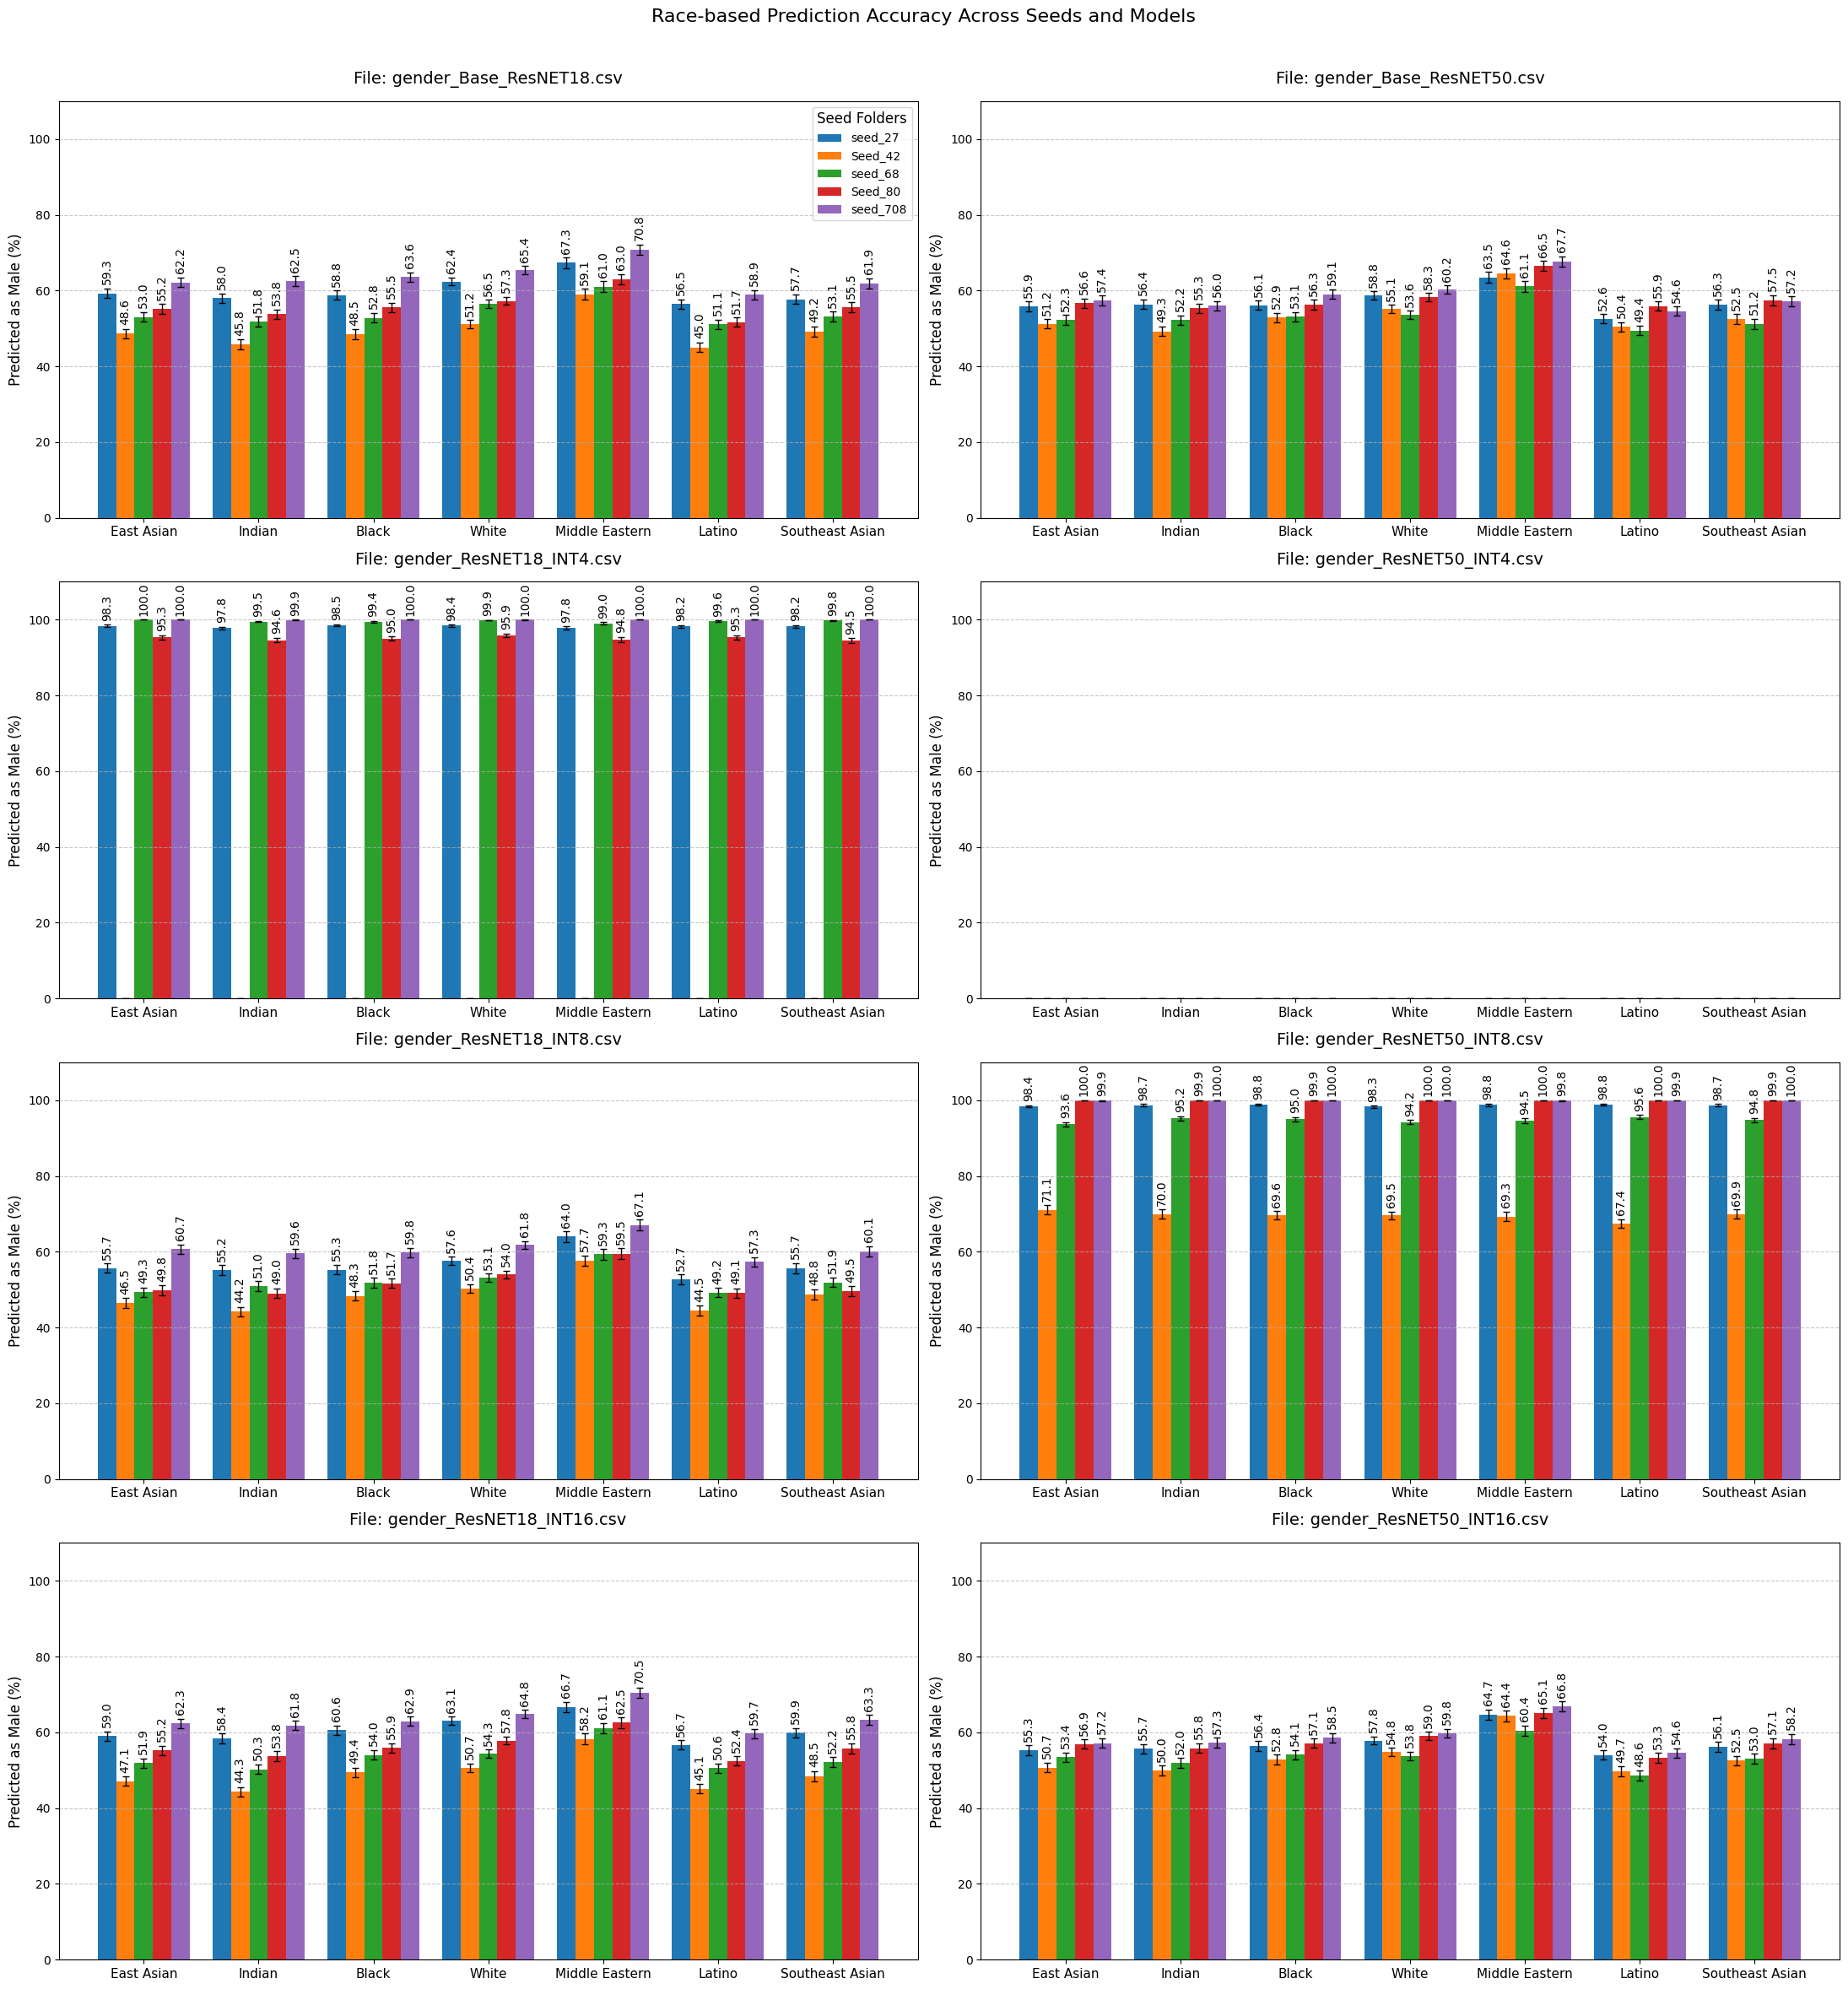

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import List, Dict, Tuple

def calculate_accuracy_stats(df: pd.DataFrame) -> Dict[int, Tuple[float, float, int]]:
    """
    Calculate accuracy percentage and standard deviation for each race category.
    
    Args:
        df: DataFrame with 'race' and 'prediction' columns
        
    Returns:
        Dictionary mapping race categories to (accuracy_percentage, std_dev, count)
    """
    # Group by race and calculate prediction statistics
    stats = {}
    
    for race in range(7):  # 0-6 race categories
        race_df = df[df['race'] == race]
        
        if len(race_df) > 0:
            # Calculate accuracy and standard deviation
            accuracy = race_df['prediction'].mean() * 100
            
            # Calculate binomial standard deviation: sqrt(p*(1-p)/n)
            p = accuracy / 100
            n = len(race_df)
            std_dev = np.sqrt(p * (1-p) / n) * 100 if n > 0 else 0
            
            stats[race] = (accuracy, std_dev, n)
        else:
            stats[race] = (0, 0, 0)
            
    return stats

def plot_race_accuracy_with_seeds(base_dirs: List[str], file_names: List[str], output_file: str = 'race_prediction_accuracy.png'):
    """
    Create a 4x2 subplot with grouped bar charts showing prediction accuracy by race for each file across multiple seeds.
    
    Args:
        base_dirs: List of base directories (seed folders)
        file_names: List of file names to process in each directory
        output_file: Path to save the output image
    """
    # Race category labels
    race_labels = {
        0: "East Asian",
        1: "Indian", 
        2: "Black",
        3: "White",
        4: "Middle Eastern",
        5: "Latino",
        6: "Southeast Asian"
    }
    
    # Seed folder labels for legend
    seed_labels = [os.path.basename(d) for d in base_dirs]
    
    # Create figure and subplots
    fig, axes = plt.subplots(4, 2, figsize=(22, 24))
    axes = axes.flatten()
    
    # Number of race categories and seed directories
    n_races = 7
    n_seeds = len(base_dirs)
    
    # Width of each bar
    bar_width = 0.8 / n_seeds  # Adjust this for bar spacing
    
    # Process each file
    for i, file_name in enumerate(file_names):
        if i >= 8:  # Ensure we only process 8 files
            break
            
        ax = axes[i]
        ax.set_title(f'File: {os.path.basename(file_name)}', fontsize=14, pad=15)
        
        # Track if at least one file was processed successfully
        file_processed = False
        
        # Store data for all seeds for this file
        all_seed_data = {}
        
        # Process each seed directory
        for seed_idx, base_dir in enumerate(base_dirs):
            file_path = os.path.join(base_dir, file_name)
            
            try:
                # Read CSV
                if os.path.exists(file_path):
                    df = pd.read_csv(file_path)
                    
                    # Calculate accuracy statistics
                    stats = calculate_accuracy_stats(df)
                    
                    # Store data for this seed
                    all_seed_data[seed_idx] = stats
                    file_processed = True
                else:
                    print(f"Warning: File not found: {file_path}")
                    
            except Exception as e:
                print(f"Error processing {file_path}: {str(e)}")
        
        # If at least one file was processed, create the bar plot
        if file_processed:
            # Plot grouped bars for each race category
            for race in range(n_races):
                # X position for this race group
                x_pos = race
                
                # Plot bars for each seed
                for seed_idx in range(n_seeds):
                    if seed_idx in all_seed_data:
                        # Get data for this seed and race
                        if race in all_seed_data[seed_idx]:
                            accuracy, std_dev, _ = all_seed_data[seed_idx][race]
                            
                            # Calculate position for this bar within the group
                            bar_pos = x_pos + (seed_idx - n_seeds/2 + 0.5) * bar_width
                            
                            # Plot the bar
                            bar = ax.bar(
                                bar_pos, 
                                accuracy, 
                                width=bar_width, 
                                yerr=std_dev,
                                capsize=3,
                                color=plt.cm.tab10(seed_idx % 10),  # Use colormap for different seeds
                                error_kw={'ecolor': 'black', 'lw': 1, 'capthick': 1, 'capsize': 3},
                                label=seed_labels[seed_idx] if race == 0 else None  # Only add to legend once
                            )
                            
                            # Add value labels for bars higher than 5%
                            if accuracy > 5:
                                ax.text(
                                    bar_pos,
                                    accuracy + std_dev + 1,
                                    f'{accuracy:.1f}',
                                    ha='center',
                                    va='bottom',
                                    fontsize=10,
                                    rotation=90
                                )
            
            # Set x-axis ticks and labels
            ax.set_xticks(range(n_races))
            ax.set_xticklabels([race_labels[r] for r in range(n_races)], fontsize=11)
            plt.setp(ax.get_xticklabels(), rotation=0, ha='center')
            
            # Set y-axis label and limit
            ax.set_ylabel('Predicted as Male (%)', fontsize=12)
            ax.set_ylim(0, 110)  # Set y-axis from 0-110% to have space for labels
            
            # Add gridlines for readability
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            
            # Add a legend to the first subplot only
            if i == 0:
                ax.legend(title="Seed Folders", fontsize=10, title_fontsize=12)
                
        else:
            # If no files were processed successfully
            ax.text(0.5, 0.5, f"No data available for {os.path.basename(file_name)}", 
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax.transAxes, fontsize=12, color='red')
    
    # Hide any unused subplots
    for j in range(i+1, 8):
        axes[j].set_visible(False)
    
    # Add common title and adjust layout
    plt.suptitle('Race-based Prediction Accuracy Across Seeds and Models', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Save figure
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Visualization saved to {output_file}")
    
    # Show plot
    plt.show()

# Example usage
if __name__ == "__main__":
    # Base seed directories
    seed_dirs = [
        "../results/ResFair/seed_27",
        "../results/ResFair/Seed_42",
        "../results/ResFair/seed_68",
        "../results/ResFair/Seed_80",
        "../results/ResFair/seed_708"
    ]
    
    # File names to process in each seed directory
    file_names = [
        "gender_Base_ResNET18.csv",
        "gender_Base_ResNET50.csv",
        "gender_ResNET18_INT4.csv",
        "gender_ResNET50_INT4.csv",
        "gender_ResNET18_INT8.csv",
        "gender_ResNET50_INT8.csv",
        "gender_ResNET18_INT16.csv",
        "gender_ResNET50_INT16.csv"
    ]
    
    # Check if directories exist
    existing_dirs = [d for d in seed_dirs if os.path.exists(d)]
    if len(existing_dirs) < len(seed_dirs):
        missing_dirs = [d for d in seed_dirs if d not in existing_dirs]
        print(f"Warning: The following directories were not found: {', '.join(missing_dirs)}")
    
    if existing_dirs:
        # Process the files in existing directories
        print(f"Processing files across {len(existing_dirs)} seed directories...")
        plot_race_accuracy_with_seeds(existing_dirs, file_names)
    else:
        print("No seed directories found. Please check the directory paths.")